In [469]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.optimize import minimize

import emcee
import corner

In [91]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

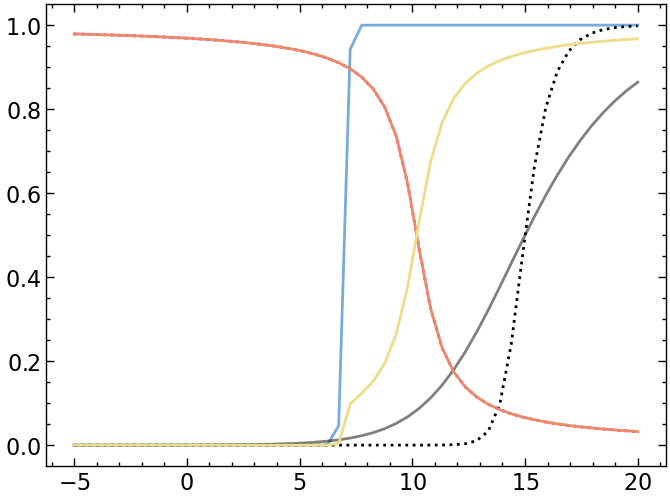

In [709]:
xx = np.linspace(-5, 20)
x0 = 7
plt.plot(xx, 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (xx - x0))))

a = 1.
b = .5
l = 10.2
sigma_x = 1
# Optically Obscured
# L_x ~ Ms, so this should hold
f_obs = a*(1/2 + 1/np.pi*np.arctan((l - xx)/sigma_x)) # + b
plt.plot(xx, f_obs , color='m', linestyle='dotted')

xi = 0.0
a = .5
f1 = 1 - (1 + 3*(10**xx/1e15)**(1 - 2*xi))**-a
plt.plot(xx, f1 , color='k', linestyle='dotted')

f1 = 1 - (1 + 3*(10**((xx - 15)/4))**(1 - 2*xi))**-a
plt.plot(xx, f1 , color='k', alpha=0.5)

plt.plot(xx, (f_obs) )
plt.plot(xx, (1- f_obs) * 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (xx - x0))))

In [790]:
def f_X(x, alpha, beta, x0, sigma_x=0.46, l0=43.89, a=1):

    l0 = 43.89-39 #TODO: Should really move this to prior
    #sigma_x = 0.46
    
    # Obscured function (Merloni 2014)
    lx = alpha + beta * x
    fobsc = a*(1/2 + 1/np.pi*np.arctan((l0 - lx)/sigma_x))

    # Occupation function (Miller 2015)
    focc = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (x - x0)))
    
    return np.clip((1 - fobsc)*focc, 1e-6, 1)

def f_var(x, alpha, beta, x0, xi, l0):
    
    # Obscured function (Oh 2015; https://ui.adsabs.harvard.edu/abs/2015ApJS..219....1O/abstract)
    l = alpha + beta * x
    sigma_1 = 1
    #xi = 0
    f1 = 1 - (1 + 3 * (10**((l - l0)/sigma_1))**(1 - 2*xi))**-0.5    

    # Occupation function (Miller 2015)
    focc = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (x - x0)))
    
    return np.clip(f1*focc, 1e-6, 1)

def log_likelihood(theta, x, y, xerr, yerr, sigma_var):
    
    # parameters to be fit
    log_ms0, alpha, beta, log_f, xi_1, l0_1 = theta
    
    # Residuals
    sigma2 = yerr**2 + np.exp(2*log_f)**2 + (beta*xerr)**2
    z = (y - alpha - beta*x)/np.sqrt(sigma2)
    
    # p(y|x)
    f = 1/np.sqrt(sigma2*2*np.pi)*np.exp(-z**2/2)

    # Likelihood
    mask_det = (yerr > 0)
    S = st.poisson.sf(-z[~mask_det], mu=0) # Integral of Poisson distribution

    # p(D|x,y) weights
    if sigma_var is None:
        p_det = 1
        p_lim = 1
    else:
        p_det = np.clip(st.halfnorm.cdf(sigma_var[mask_det]), 1e-12, 1)
        p_lim = np.clip(st.halfnorm.sf(sigma_var[~mask_det]), 1e-12, 1) # 1 - cdf

    f_occ_det = f_var(x[mask_det], alpha, beta, log_ms0, xi_1, l0_1)
    f_occ_cens = f_var(x[~mask_det], alpha, beta, log_ms0, xi_1, l0_1)
    
    # Likelihood
    ll_det = np.log(p_det * f_occ_det * f[mask_det])
    ll_cens = np.log(p_lim * (f_occ_cens * S + 1 - f_occ_cens))

    ll = np.sum(ll_det) + np.sum(ll_cens)
    
    return ll

def log_likelihood_X(theta, x, y, xerr, yerr, sigma_var):
    
    # parameters to be fit
    log_ms0, alpha, beta, log_f, log_f_x, l0_x = theta
    
    # Residuals
    sigma2 = yerr**2 + np.exp(2*log_f)**2 + (beta*xerr)**2
    z = (y - alpha - beta*x)/np.sqrt(sigma2)
    
    # p(y|x)
    f = 1/np.sqrt(sigma2*2*np.pi)*np.exp(-z**2/2)

    # Likelihood
    mask_det = (yerr > 0)
    S = st.poisson.sf(-z[~mask_det], mu=0) # Integral of Poisson distribution

    # p(D|x,y) weights
    if sigma_var is None:
        p_det = 1
        p_lim = 1
    else:
        p_det = np.clip(st.halfnorm.cdf(sigma_var[mask_det]), 1e-12, 1)
        p_lim = np.clip(st.halfnorm.sf(sigma_var[~mask_det]), 1e-12, 1) # 1 - cdf

    sigma_x = np.exp(2*log_f_x)
    f_occ_det = f_X(x[mask_det], alpha, beta, log_ms0, sigma_x, l0_x)
    f_occ_cens = f_X(x[~mask_det], alpha, beta, log_ms0, sigma_x, l0_x)
    
    # Likelihood
    ll_det = np.log(p_det * f_occ_det * f[mask_det])
    ll_cens = np.log(p_lim * (f_occ_cens * S + 1 - f_occ_cens))

    ll = np.sum(ll_det) + np.sum(ll_cens)
    
    return ll

def log_likelihood_init(theta, x, y, xerr, yerr):
    
    # parameters to be fit
    alpha, beta, log_f = theta

    if beta < 0:
        return -np.inf

    sigma2 = yerr**2 + np.exp(2*log_f)**2 + (beta*xerr)**2
    z = (y - alpha - beta*x)/np.sqrt(sigma2)
    
    mask_det = (yerr > 0)
    
    f = 1/np.sqrt(sigma2*2*np.pi)*np.exp(-z**2/2)
    
    ll = np.sum(np.log(f[mask_det]))
    
    return ll

In [749]:
def log_prior(theta):
    logms0, alpha, beta, log_f, xi_1, l0_1 = theta
    # Priors
    if -5.0 < logms0 < 5.0 and -5.0 < alpha < 5.0 and 0.0 < beta < 5.0 and -2.0 < log_f < 0.0 and \
    -0.49 < xi_1 < 0.49 and 0 < l0_1 < 10.5: #  0.0 < l0_x < 10.5:
        return 0.0
    return -np.inf

def log_prior_X(theta):
    logms0, alpha, beta, log_f, log_fx, l0_x = theta
    # Priors
    if -5.0 < logms0 < 5.0 and -5.0 < alpha < 5.0 and 0.0 < beta < 5.0 and -2.0 < log_f < 0.0 and \
    -2.0 < log_fx < 2.0 and 0.0 < l0_x < 7.0: #  0.0 < l0_x < 7.0:
        return 0.0
    return -np.inf

In [662]:
def log_probability(theta, x, y, xerr, yerr, sigma_var):
    lp = log_prior(theta)
    ll = log_likelihood(theta, x, y, xerr, yerr, sigma_var)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

def log_probability_X(theta, x, y, xerr, yerr, sigma_var):
    lp = log_prior_X(theta)
    ll = log_likelihood_X(theta, x, y, xerr, yerr, sigma_var)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [786]:
def inference(log_prob, x, y, xerr, yerr, sigma_var=None, init_extra=[0, 0], alpha_dat=1,
              labels_extra=[r'$\xi$', r'$\log L_0$'], xp=10.5, yp=39.0, nsamp=10000, nburn=1000,
              scale_hist=1, ylabel='y', color='C1', xlims=[None, None], ylims=[None, None]):

    x = x-xp
    y = y-yp

    np.random.seed(42)
    nll = lambda *args: -log_likelihood_init(*args)
    
    initial = np.array([0.0, 0.5, np.log(0.2)])
    initial += 0.1 * np.random.randn(len(initial))
    soln = minimize(nll, initial, args=(x, y, xerr, yerr))
    alpha_ml, beta_ml, log_f_ml = soln.x
    
    print("Maximum likelihood estimates:")
    print("alpha = {0:.3f}".format(alpha_ml+yp))
    print("beta = {0:.3f}".format(beta_ml))
    print("sigma = {0:.3f}".format(np.exp(2*log_f_ml)))

    pos = [-4, soln.x[0], soln.x[1], soln.x[2]] + init_extra
    pos = np.array(pos) + 1e-2 * np.random.randn(32, len(pos))
    nwalkers, ndim = pos.shape
    
    # Sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, xerr, yerr, sigma_var))
    
    sampler.run_mcmc(pos, nsamp, progress=True);
    
    # Plot
    fig, axes = plt.subplots(ndim, figsize=(12, 7), sharex=True)
    samples = sampler.get_chain()

    labels = [r"$\log M_{\ast,0}$", r"$\alpha$", r"$\beta$", r"$\sigma$"] + labels_extra
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    
    axes[-1].set_xlabel("step number");

    #tau = sampler.get_autocorr_time()
    #print(tau)
    
    flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)
    print(flat_samples.shape)

    # Corner
    flat_samples[:,3] = np.exp(2*flat_samples[:,3]) # sigma
    flat_samples[:,0] += xp # log M_*,0
    flat_samples[:,1] += yp # alpha
    flat_samples[:,5] += yp # 
    fig_corner = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.84])

    # TODO::::: Increase the 1st column limit + 1 and use 95th percentile

    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
    #inds = np.random.randint(len(flat_samples), size=100)

    # Plot data
    x_eval = np.linspace(-5, 5)
    axes[0].scatter(x[yerr > 0] + xp, y[yerr > 0] + yp, marker='.', color='k')
    axes[0].errorbar(x[yerr > 0] + xp, y[yerr > 0] + yp, elinewidth=1,
                     xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                     fmt=".k", capsize=0, alpha=alpha_dat)
    # Pick random
    if len(x[yerr < 0]) > 50:
        ind_rand = np.random.choice(len(x[yerr < 0]), 50, replace=False)
    else:
        ind_rand = np.arange(len(x[yerr < 0]))
    axes[0].scatter(x[yerr < 0][ind_rand] + xp, y[yerr < 0][ind_rand] + yp, marker='v', color='gray', zorder=-1)
    axes[0].errorbar(x[yerr < 0][ind_rand] + xp, y[yerr < 0][ind_rand] + yp,
                     xerr=xerr[yerr < 0][ind_rand], elinewidth=1,
                     marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1)
    axes[0].legend(fontsize=14)
    axes[0].set_xlim(xlims)
    axes[0].set_ylim(ylims)
    axes[0].set_xlabel(r"$\log(M_{\ast} / M_{\odot})$")
    axes[0].set_ylabel(ylabel)

    # Linear relation
    relation = np.zeros([len(flat_samples), len(x_eval)])
    for i, s in enumerate(flat_samples):
        relation[i,:] = np.dot(np.vander(x_eval, 2), [s[2], s[1]])

    axes[0].fill_between(x_eval + xp, np.percentile(relation, 84, axis=0), np.percentile(relation, 16, axis=0),
                         color=color, alpha=0.3, zorder=2)

    # Limits
    log_ms0_low = np.percentile(flat_samples[:,0], 95)
    log_ms0_high = np.percentile(flat_samples[:,0], 1)
    print('95% CI: ', log_ms0_low)

    # Occupation fraction
    alpha50 = np.median(flat_samples[:,1])
    beta50 = np.median(flat_samples[:,2])
    f_occ_low = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_low) * (x_eval + xp - log_ms0_low)))
    f_occ_high = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_high) * (x_eval + xp - log_ms0_high)))

    axes[1].plot(x_eval + xp, f_occ_low, color, alpha=0.1)
    axes[1].fill_between(x_eval + xp, f_occ_high,  f_occ_low, color=color, alpha=0.3)

    xi50 = np.median(flat_samples[:,4])
    l050 = np.median(flat_samples[:,5])
    print('a, b = ', alpha50, beta50)
    axes[1].plot(x_eval + xp, scale_hist*f_var(x_eval, alpha50-yp, beta50, -5, xi50, l050 - yp),
                 color=color, alpha=1, linestyle='dashed')
    
    # Histogram
    hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(-3, 3, 0.5))
    hist_all, bin_edges = np.histogram(x,  bins=np.arange(-3, 3, 0.5))
    frac_det = hist_det/hist_all

    axes[1].errorbar(bin_edges[1:] + np.diff(bin_edges)[0] + xp, scale_hist*frac_det,
                     yerr=scale_hist*st.binom.std(hist_all, frac_det)/hist_all, color="k", capsize=0)
    axes[1].set_xlim(xlims)
    axes[1].set_ylim([None, 1])
    axes[1].set_xlabel(r"$\log(M_{\ast} / M_{\odot})$")
    axes[1].set_ylabel(r"Occupation Fraction")

    fig.tight_layout()

    return fig_corner, fig, flat_samples[:,0]
    

In [617]:
# set up our data
N = 400  # number of data points
sigmatrue = 0.08  # standard deviation of noise
x = np.linspace(7.0, 12.0, N) # log Ms
flag_lim = np.zeros_like(x) # upper limit flag

_xerr = 0.3
_yerr = 0.1

mtrue = 0.8  # true gradient
ctrue = 31  # true y-intercept
#ctrue = 47
logms0true = 6.5 # occupation fraction pivot mass
low = 38.0 # detection limit

# make data
p_occ = 0.5*(1 + np.tanh(2.5**np.abs(8.9 - logms0true) * (x - logms0true)))
# Generate data
I_occ = np.random.binomial(1, p_occ)

y = I_occ*st.norm.rvs(ctrue + mtrue*x, np.sqrt(_yerr**2 + sigmatrue**2), size=len(x))
x = st.norm.rvs(x, _xerr, size=len(x))

# detection limits
mask = y < low
flag_lim[mask] = 1
y = np.clip(y, low, None)

# Random
#y[::2] = 40 # every Nth point set to low
#flag_lim[::2] = 1

xerr = np.full_like(y, _xerr)
yerr = np.full_like(y, -1.0)
yerr[flag_lim==0] = _yerr
#yerr = np.full_like(y, _yerr)

sigma_var = np.full_like(y, 60)
sigma_var[flag_lim==1] = 0

In [243]:
#_,_ = inference(x, y, xerr, yerr, sigma_var, nburn=500, nsamp=2000)

# Ohlson 50 Mpc X-ray

In [181]:
#data[(data['chandra_observation']==1) & (data['chandra_detection']==0)]

In [ ]:
data['log_lx'][data['chandra_observation']==1]

['objname', 'pgc', 'nsaid', 'group_id', 'ra', 'dec', 'ra_nsa', 'dec_nsa', 'ra_ned', 'dec_ned', 'd25', 'v_h', 'v_cmb', 'v_source', 'hl_obj', 'lvg_obj', 'nsa_obj', 'sga_obj', 't_type', 'color_type', 'best_type', 'a_B_leda', 'a_g_nsa', 'EBV_irsa', 'Bt0_leda', 'BV_color_leda', 'B_lum', 'gi_color_nsa', 'i_lum_nsa', 'gr_color_sga', 'r_lum_sga', 'BR_color_ned', 'R_lum_ned', 'BMag', 'gi_color', 'mag_flag', 'cf3_dist', 'cf3_dist_error', 'zind_dist', 'zind_dist_error', 'zind_indicator', 'bestdist', 'bestdist_error', 'bestdist_method', 'bestdist_source', 'dist_ned_flag', 'logmass_gi', 'logmass_gr', 'logmass_BV', 'logmass_BR', 'logmass', 'logmass_error', 'logmass_src', 'chandra_observation', 'chandra_detection', 'log_lx', 'chandra_detection_3arcsec', 'log_lx_3arcsec']
Maximum likelihood estimates:
alpha = 39.510
beta = 0.757
sigma = 0.877


  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]/Users/colinburke/miniconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 198.19it/s]


(6400, 6)


95% CI:  7.841961018867638
0
[-7.82313286 -7.55727711 -7.29142135 -7.0255656  -6.75970984 -6.49385409
 -6.22799833 -5.96214258 -5.69628682 -5.43043107 -5.16457532 -4.89871956
 -4.63286381 -4.36700805 -4.1011523  -3.83529654 -3.56944079 -3.30358503
 -3.03772928 -2.77187353 -2.50601777 -2.24016202 -1.97430626 -1.70845051
 -1.44259475 -1.176739   -0.91088324 -0.64502749 -0.37917173 -0.11331598
  0.15253977  0.41839553  0.68425128  0.95010704  1.21596279  1.48181855
  1.7476743   2.01353006  2.27938581  2.54524156  2.81109732  3.07695307
  3.34280883  3.60866458  3.87452034  4.14037609  4.40623185  4.6720876
  4.93794335  5.20379911]


NameError: name 'ij' is not defined

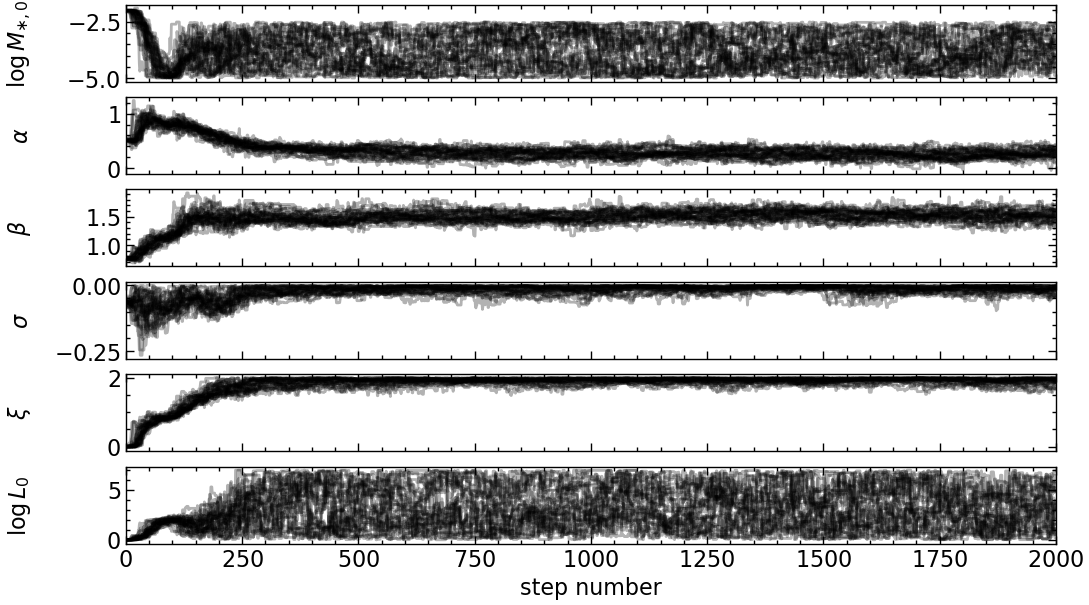

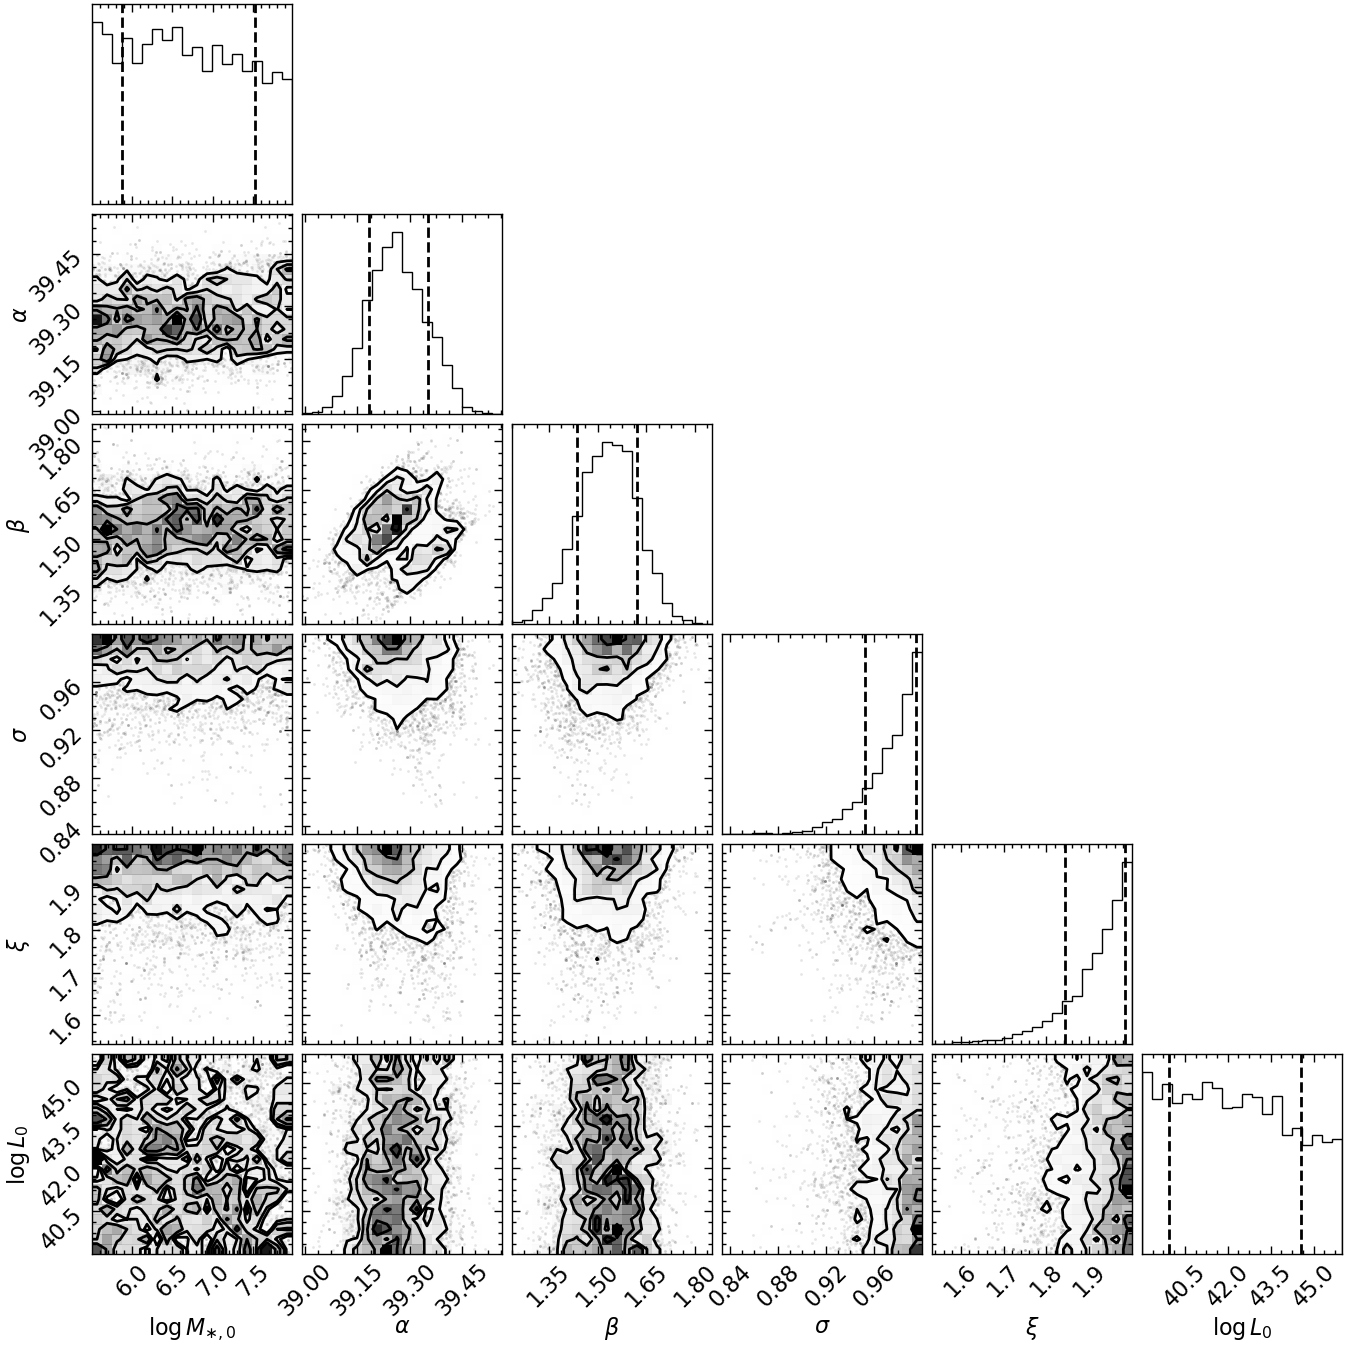

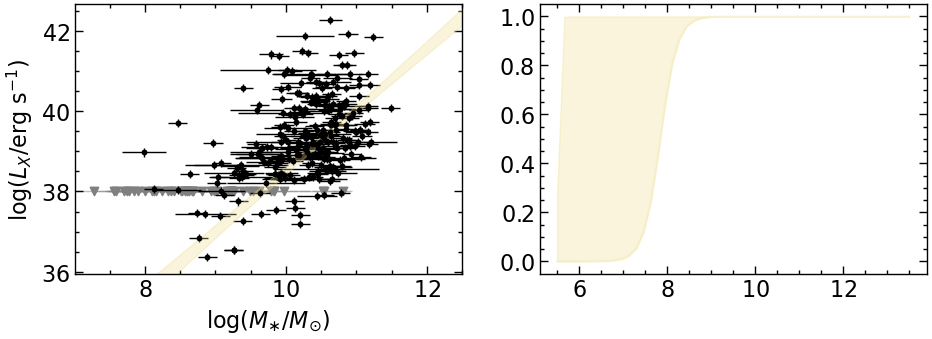

In [693]:
hdul = fits.open('catalog.fits')
data = hdul[1].data
print(data.columns.names)

x = data['logmass']
y = data['log_lx']
xerr = data['logmass_error']

# Restrict to those with stellar mass and Chandra observation
mask = np.isfinite(x) & (data['chandra_observation'] == 1)
x = x[mask]
y = y[mask]
xerr = xerr[mask]

yerr = np.full_like(y, 0.1)
mask = ~np.isfinite(y)
y[mask] = 38.0 ### TEMP, need real limits
yerr[mask] = -1

fig_corner, fig, log_ms0_ohlson = inference(log_probability_X, x, y, xerr, yerr, yp=39, nsamp=2000, xlims=[7, 12.5], color='C2',
                                ylabel=r'$\log(L_{X} / {\rm{erg}}\ {\rm{s}}^{-1})$')

# AMUSE

Maximum likelihood estimates:
alpha = 39.001
beta = 0.650
sigma = 0.458


  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]/Users/colinburke/miniconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 297.04it/s]


(6400, 6)


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_9985/1809510760.py:115: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


95% CI:  9.165367047968827
a, b =  38.91785013883569 0.7855163350355171


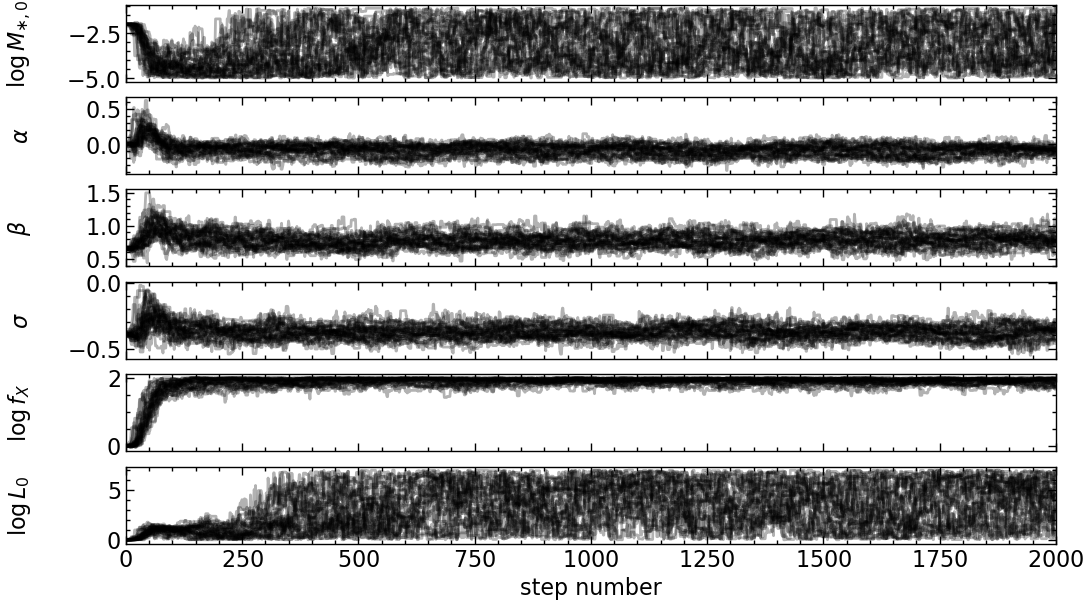

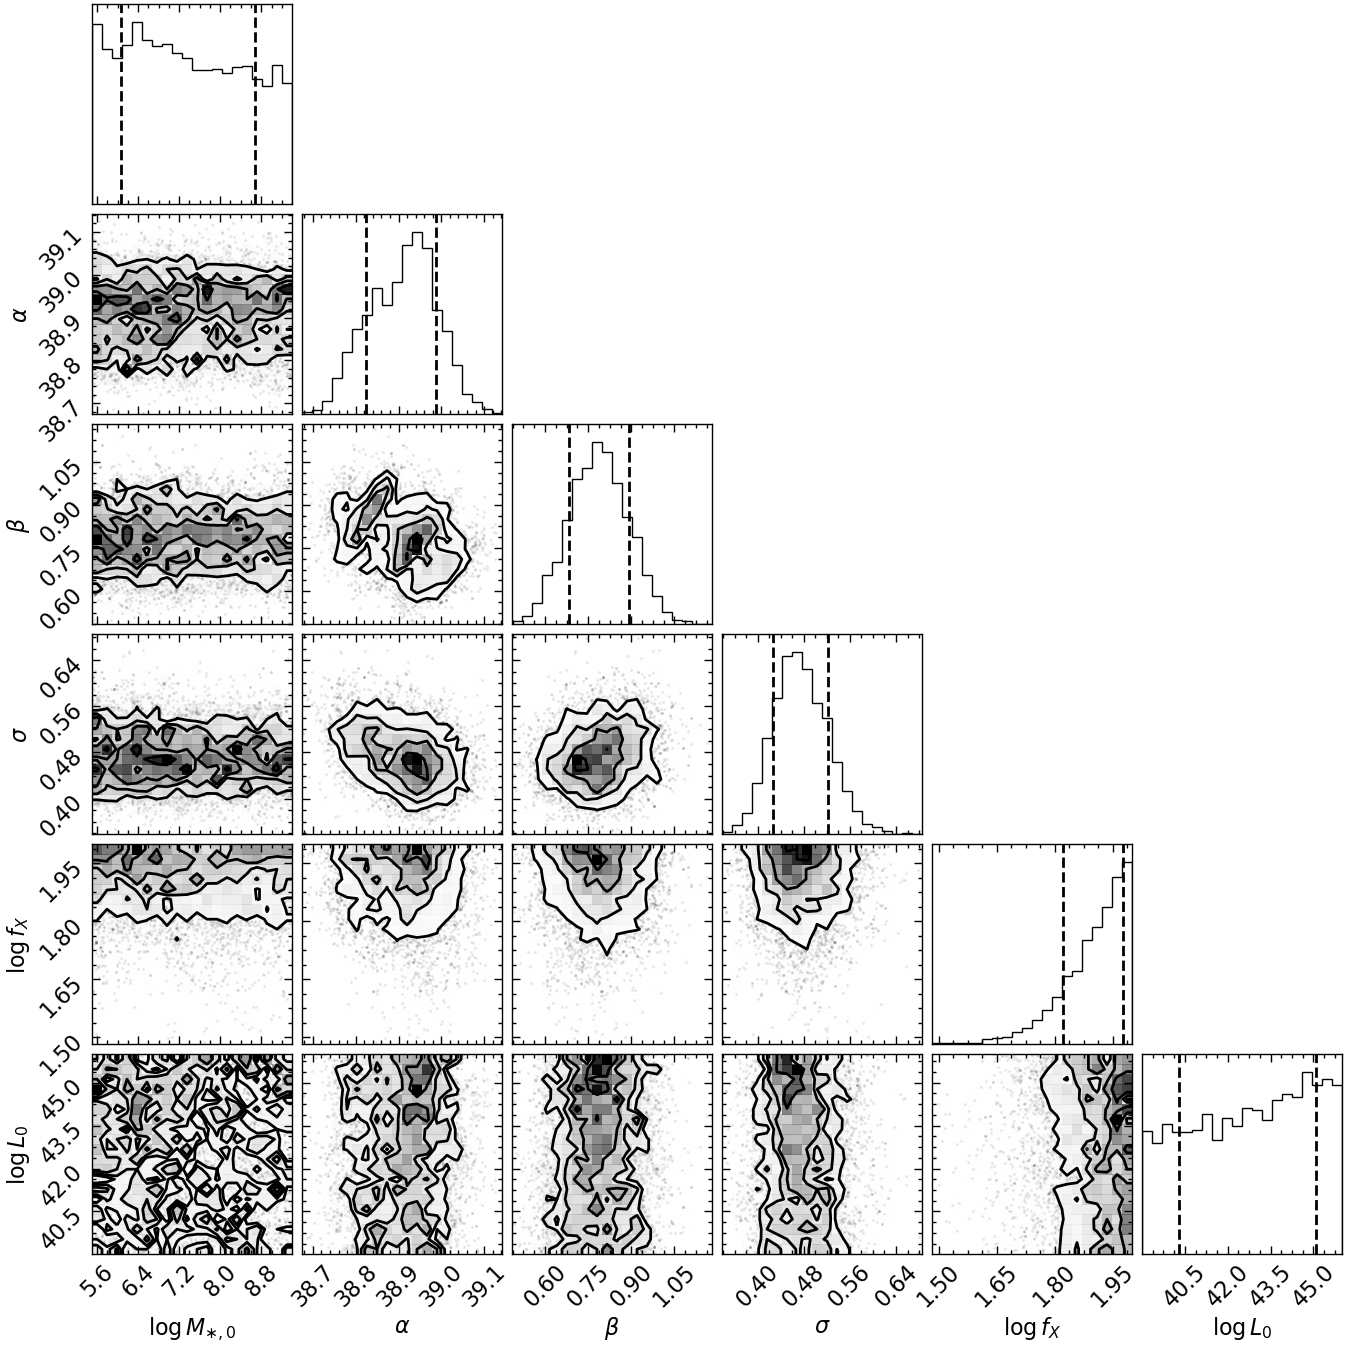

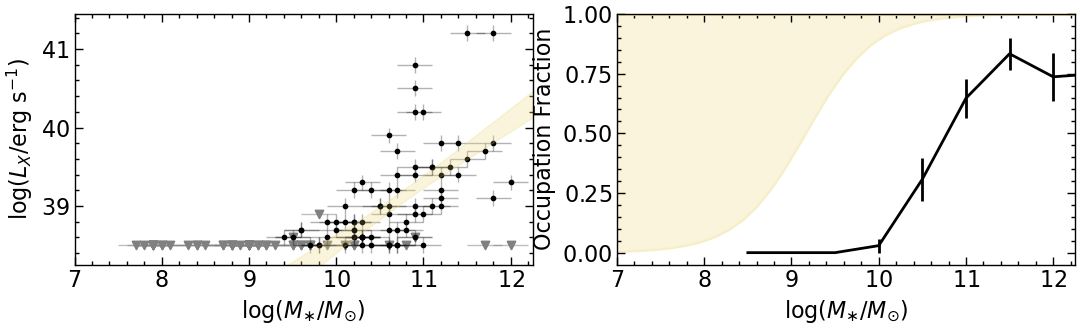

In [711]:
Lx_dat = ascii.read('miller15.txt', names=['Ms', 'Lx', 'SF'])
Lx_dat = Lx_dat[Lx_dat['SF']=='clean'] # clean sample
# Remove sources


# Read the table, if the luminosity is an upper limit, add a flag
Lx_dat['flag_lim'] = 0
for i, Lxi in enumerate(Lx_dat['Lx']):
    if '<' in Lxi:
        Lx_dat['Lx'][i] = Lxi[1:] #Lxi[1:] # Asumme uniform lower-limit is 38.5
        Lx_dat['flag_lim'][i] = 1
Lx_dat['Lx'] = np.array(Lx_dat['Lx'].data, dtype=float)

Lx_dat['Lx'] = np.clip(Lx_dat['Lx'], 38.5, None)

#Lx_dat = Lx_dat[Lx_dat['flag_lim'] == 0]
#Lx_dat = Lx_dat[Lx_dat['Ms'] > 9]

x = Lx_dat['Ms'].data
y = Lx_dat['Lx'].data


# remove the outliers < 1e9

xerr = np.full_like(y, 0.2)
yerr = np.full_like(y, 0.1)
yerr[Lx_dat['flag_lim']==1] = -1

fig_corner, fig, log_ms0_miller = inference(log_probability_X, x, y, xerr, yerr, yp=39, nsamp=2000, alpha_dat=0.3,
                                            labels_extra=[r'$\log f_X$', r'$\log L_0$'], xlims=[7, 12.25],
                                            color='C2', ylabel=r'$\log(L_{X} / {\rm{erg}}\ {\rm{s}}^{-1})$')
fig.savefig('inferencemiller.pdf', dpi=300)

# Variability

In [633]:
import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg

,ObjID,RA,Dec,Band,Npoints,Baseline,MedMag,Std,SigVary,SigQSO,SigNotQSO,Mstar,BPT,z
0,NSA32338,165.256867,49.968744,r,123,1876.02589,17.749872,0.008631,0.000000,1.378457,0.000000,1.347324e+10,1,0.045975
1,NSA4610,263.755215,57.052434,r,261,1552.00244,17.271377,0.014718,0.404314,1.561055,0.008240,6.369121e+08,1,0.047232
2,NSA30953,190.016963,5.484322,r,186,1774.15069,18.201661,0.031287,3.581902,1.176183,1.697150,4.655426e+09,2,0.047386
3,NSA6367,17.185509,0.941887,r,75,1212.94767,18.781172,0.027467,0.466396,1.113544,0.064007,3.298825e+08,1,0.040420
4,NSA12399,149.388954,1.701861,r,184,1182.86855,17.649527,0.012437,0.000000,1.014212,0.000000,3.649561e+09,0,0.032325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47120,NSA119685,182.199343,25.470923,r,218,1900.81628,16.150584,0.010685,8.987026,0.134305,3.366924,1.039090e+10,1,0.022872
47121,NSA119691,182.163939,25.128078,r,76,1897.89558,17.867995,0.012757,0.000018,0.490913,0.000005,3.038229e+09,0,0.021400
47122,NSA119698,182.524738,25.643881,r,190,1898.02892,18.336291,0.021606,0.005687,1.522762,0.000975,1.813785e+09,1,0.022505
47123,NSA116797,151.718095,14.004573,r,24,419.77577,17.186348,0.090091,37.128506,0.506742,8.076571,1.144293e+10,3,0.029382


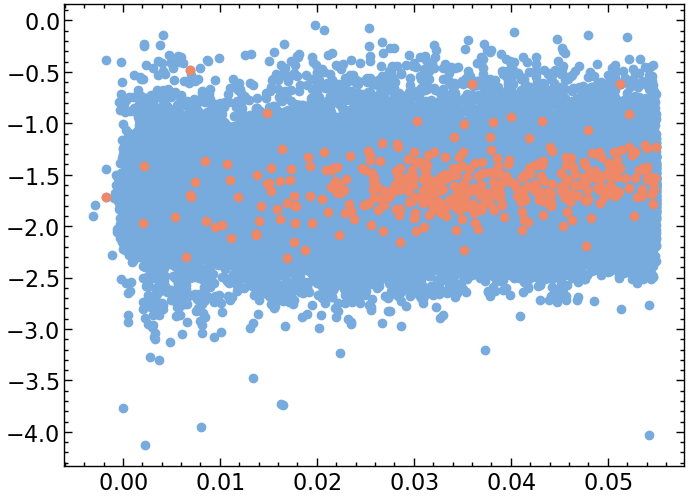

In [606]:
mask_det = (data_bgg['SigQSO'] > 2) & (data_bgg['SigVary'] > 2) & (data_bgg['SigQSO'] > data_bgg['SigNotQSO'])


plt.scatter(data_bgg['z'], np.log10(data_bgg['Std']))
plt.scatter(data_bgg['z'][mask_det], np.log10(data_bgg['Std'][mask_det]))

In [ ]:
plt.scatter(x, np.log10(L))
#x = np.linspace(25, 28)

# MacLeod
x_sub = np.logspace(6, 8)
B = -0.479
C = 0.118 
D = 0.118
lambda_Edd = .1
L_bol = lambda_Edd * 1.26*1e38 * x_sub
Mi = 90 - 2.5*np.log10(L_bol)

logdm = -0.476 + B*np.log10(6000/4000) + C*(Mi + 23) + D*np.log10(x_sub/1e9) # dm
dm = 10**logdm
L_R = 0.1*L_bol # This is actually host galaxy luminosity, which does not scale with L_bol
dL = np.log10( np.log(10)/2.5*L_R*dm ) # df

plt.plot(np.log10(x_sub)+3, np.log10(L_R)-15, color='r') # slope = -2.5

In [ ]:
import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')

mask_det = (data_bgg['SigQSO'] > 2) & (data_bgg['SigVary'] > 2) & (data_bgg['SigQSO'] > data_bgg['SigNotQSO'])

mask_non = (data_bgg['SigVary'] < 2)

mask = data_bgg['Mstar'] > 1e7
#mask_z = (data_bgg['z'] > 0.03) & (data_bgg['z'] < 0.04)
#mask_z = (data_bgg['z'] > 0.02) & (data_bgg['z'] < 0.03)
mask_z = (data_bgg['z'] > 0.01) & (data_bgg['z'] < 0.02)


# TODO: Remove Kimnan galaxy and the sources < 1e7


data_bgg = data_bgg[mask & mask_z]

data_bgg_det = data_bgg[mask_det]
data_bgg_non = data_bgg[mask_non]

x = np.log10(np.concatenate([data_bgg_det['Mstar'], data_bgg_non['Mstar']]))

m = np.concatenate([data_bgg_det['MedMag'], data_bgg_non['MedMag']])
# Use 2-3* rms as the upper limit
dm = np.concatenate([data_bgg_det['Std'], data_bgg_non['Std']])
z = np.concatenate([data_bgg_det['z'], data_bgg_non['z']])
sigma_var = np.concatenate([data_bgg_det['SigVary'], data_bgg_non['SigVary']])

f = 10**(23 -0.4*(m + 48.6)) # R -> f [Jy]
d_L = cosmo.luminosity_distance(z).to(u.cm).value
L = f*(4*np.pi*d_L**2) * 1e-23 # Lv [erg/s/Hz]

# Convert to dL to make things more intuitive
y = np.log10( np.log(10)/2.5*L*dm ) # dL

# introduces dL ~ L term

xerr = np.full_like(y, 0.2)
yerr = np.concatenate([len(data_bgg_det)*[0.1], len(data_bgg_non)*[-1]])

fig_corner, fig, log_ms0_bgg = inference(log_probability, x, y, xerr, yerr, sigma_var, scale_hist=10,  init_extra=[0, 2],
                                         yp=np.median(y[yerr > 0]), xlims=[7, 12.25], ylims=[None, None], nsamp=2000, alpha_dat=0.3,
                                         ylabel=r'$\log(\Delta L / {\rm{erg}}\ {\rm{s}}^{-1}\ \rm{{Hz}}^{-1} )$')

axes = fig_corner.axes
for ax in axes:
    ax.xaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontsize(30)
fig_corner.savefig('cornerbgg.pdf', dpi=300)

axes = fig.axes
x_eval = np.linspace(-5, 3)
xp = 10
log_ms0_low = np.percentile(log_ms0_bgg, 1)
log_ms0_up = np.percentile(log_ms0_bgg, 95)

# MacLeod
x_sub = np.logspace(2, 11)
B = -0.479
C = 0.118
D = 0.118
lambda_Edd = 0.1
L_bol = lambda_Edd * 1.26*1e38 * x_sub
Mi = 90 - 2.5*np.log10(L_bol)

logdm = -0.476 + B*np.log10(6000/4000) + C*(Mi + 23) + D*np.log10(x_sub/1e9) # dm
dm = 10**logdm
Ms = 1e11 * 10**((np.log10(x_sub) - 7.45)/1.05)
L_host = Ms / 10**((2.053*0.5) - 1.030) * 3.3*1e33 # Use Zibbiti M/L ratios
L_R = 0.1*L_bol #+ L_host # This is actually host galaxy luminosity, which does not scale with L_bol
dL = np.log10( np.log(10)/2.5*L_R*dm ) # df

axes[0].plot(np.log10(x_sub) + 2.5, dL - 15, label='Suberlak+21', linestyle='dashed')

fig.savefig('inferencebgg.pdf', dpi=300)


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_9985/2540160996.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_bgg_det = data_bgg[mask_det]
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_9985/2540160996.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_bgg_non = data_bgg[mask_non]
/Users/colinburke/miniconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Maximum likelihood estimates:
alpha = 26.115
beta = 0.210
sigma = 0.387


 61%|██████████████████████████████████████████████████████████▉                                      | 1215/2000 [00:20<00:13, 58.66it/s]

In [ ]:
# plt.scatter(data_bgg['z'][mask_det], y)
plt.scatter(z, y)
plt.scatter(z[yerr>0], y[yerr>0])
np.median(y[yerr > 0])

### Galaxy stellar mass function

In [428]:
def GSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)*u.Msun
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)*u.Mpc**-3
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)*u.Mpc**-3
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    #phi = np.exp(-M_star[:, np.newaxis]/M_br)/M_br * (phi1*(M_star[:, np.newaxis]/M_br)**alpha1 + phi2*(M_star[:, np.newaxis]/M_br)**alpha2)
    #phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    return phi

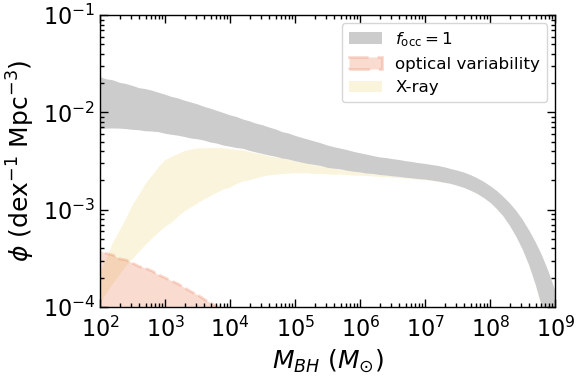

In [470]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.0))
ax.set_xscale('log')
ax.set_yscale('log')


# RV15
#alpha = 7.45
#beta = 1.05
#sigma = 0.61
#logms0 = 11

dlogmb =  0.1
logmb = np.arange(1.0, 10.5, dlogmb)
mb = 10**logmb

shape = [len(logmb), len(log_ms0_bgg)]
# total BH mass function is dominated by inactive population
# GSH20, All, limits
alpha = np.random.normal(7.43, 0.09, size=shape[1])
beta = np.random.normal(1.61, 0.12, size=shape[1])
sigma = np.random.normal(0.81, 0.06, size=shape[1])
logms0 = np.log10(3*1e10)

logms = logms0 + (logmb[:, np.newaxis] - alpha.T)/beta.T
ms = 10**logms
dms = np.diff(ms, axis=0)


N = np.random.normal(loc=alpha.T + beta.T*(logms - logms0), scale=sigma)
#
gsmf = GSMF(ms*u.Msun, size=shape[1]).value

f_occ_bgg = 0.5*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_bgg) * (logms - log_ms0_bgg.T)))
f_occ_bgg16 = np.percentile(bhmf_bgg, 16, axis=1)

f_occ_miller = 0.5*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_miller) * (logms - log_ms0_miller.T)))

bhmf_1 = (gsmf * N)[:-1,:] * dms
bhmf_bgg16 = (np.percentile((gsmf * N)[:-1,:] * dms, 16, axis=1) * np.percentile(bhmf_bgg, 16, axis=1) )
bhmf_bgg84 = (np.percentile((gsmf * N)[:-1,:] * dms, 84, axis=1) * np.percentile(bhmf_bgg, 84, axis=1) )

bhmf_miller = (gsmf * f_occ_miller * N)[:-1,:] * dms

# Plot
ax.fill_between(mb[:-1], np.percentile(bhmf_1, 16, axis=1), np.percentile(bhmf_1, 84, axis=1),
                color="k", alpha=0.2, lw=0, zorder=80, label=r'$f_{\rm occ}=1$')

ax.fill_between(mb[:-1], bhmf_bgg16, bhmf_bgg84,
                color="C1", alpha=0.3, label='optical variability', lw=2, ls='dashed')

ax.fill_between(mb[:-1], np.percentile(bhmf_miller, 16, axis=1), np.percentile(bhmf_bgg, 16, axis=1),
                color="C2", alpha=0.3, zorder=-1, label='X-ray', lw=0)


# TODO: interp and use two seeding models 

ax.set_ylim(1e-4, 1e-1)
ax.set_xlim(1e2, 1e9)

ax.set_xlabel(r'$M_{BH}\ (M_{\odot})$', fontsize=18)
ax.set_ylabel(r'$\phi$ (dex$^{-1}$ Mpc$^{-3}$)', fontsize=18)

### SAM
#sam = ascii.read('sam.txt')
#ax.plot(10**sam['col1'], 10**sam['col2'], color='r', zorder=-1, lw=3, label='SAM $z{=}0$', linestyle='dashed')

ax.legend(fontsize=12, frameon=True, loc=1)

# Plot the z=0 LISA band

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('gsmf.pdf', dpi=300)

In [460]:
# From Hadair 2022
dat_trump = ascii.read('trump15.txt')
dat_nyguen = ascii.read('nguyen18.txt')
dat_sanchezjansser = ascii.read('sanchez-jansser19.txt')
dat_hoyer = ascii.read('hoyer21.txt')

# Freem Greene 2020
dat_greene = ascii.read('models.txt')

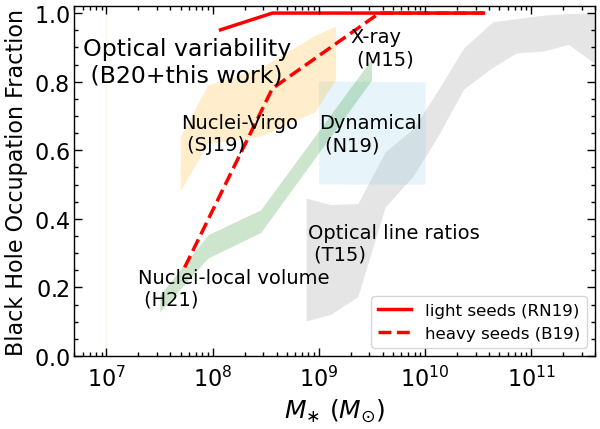

In [647]:
fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.5))
ax.set_xscale('log')

# Plot the z=0 LISA band
ax.fill_between(10**dat_trump['col1'][:12], dat_trump['col2'][:12], dat_trump['col2'][12:], color='gray', alpha=0.2, lw=0)
ax.fill_between(10**dat_nyguen['col1'][:2], dat_nyguen['col2'][:2], dat_nyguen['col2'][2:], color='skyblue', alpha=0.2, lw=0)
ax.fill_between(10**dat_sanchezjansser['col1'][:5], dat_sanchezjansser['col2'][:5], dat_sanchezjansser['col2'][5:], color='orange', alpha=0.2, lw=0)
ax.fill_between(10**dat_hoyer['col1'][:4], dat_hoyer['col2'][:4], dat_hoyer['col2'][4:][::-1], color='green', alpha=0.2, lw=0)

# Labels
ax.text(6e6, 0.8, 'Optical variability\n (B20+this work)', fontsize=17)
ax.text(5e7, 0.6, 'Nuclei-Virgo\n (SJ19)', fontsize=14)
ax.text(1e9, 0.6, 'Dynamical\n (N19)', fontsize=14)
ax.text(8e8, 0.28, 'Optical line ratios\n (T15)', fontsize=14)
ax.text(2e7, 0.15, 'Nuclei-local volume\n (H21)', fontsize=14)
ax.text(2e9, 0.85, 'X-ray\n (M15)', fontsize=14)


ax.plot(10**dat_greene['col1'][:3], dat_greene['col2'][:3], color='r', zorder=1, lw=2.5, label='light seeds (RN19)')
ax.plot(10**dat_greene['col1'][3:7], dat_greene['col2'][3:7], color='r', zorder=1, lw=2.5, linestyle='dashed', label='heavy seeds (B19)')
#ax.plot(10**dat_greene['col1'][7:], dat_greene['col2'][7:], color='k', zorder=1)

xp = 10
x_eval = np.linspace(-5, 3) + xp
log_ms0_1 = np.percentile(log_ms0_bgg, 1)
log_ms0_95 = np.percentile(log_ms0_bgg, 95)
f_occ_1 = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_1) * (x_eval - log_ms0_1)))
f_occ_95 = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_95) * (x_eval - log_ms0_95)))

ax.fill_between(10**x0, f_occ_95, f_occ_1, color='C1', alpha=0.4, zorder=-1, lw=0)

log_ms0_1 = np.percentile(log_ms0_miller, 1)
log_ms0_95 = np.percentile(log_ms0_miller, 95)
f_occ_x1 = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_1) * (x_eval - log_ms0_1)))
f_occ_x95 = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms0_95) * (x_eval - log_ms0_95)))

ax.fill_between(10**x0, f_occ_x95, f_occ_x1, color='C2', alpha=0.2)

ax.legend(fontsize=12, frameon=True, loc=4)

ax.set_ylim(0, 1.02)
ax.set_xlim(5e6, 4e11)

ax.set_xlabel(r'$M_{\ast}\ (M_{\odot})$', fontsize=18)
ax.set_ylabel(r'Black Hole Occupation Fraction', fontsize=16)

ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('occupationcombined.pdf', dpi=300)